In [ ]:
# Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score, f1_score,roc_auc_score,confusion_matrix, classification_report
from sklearn import metrics,preprocessing
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Raunak.Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Data Ingestion

Dataset link:- https://doi.org/10.24432/C5CC84

In [2]:
#Loading data
df = pd.read_csv("spam.csv",on_bad_lines='skip',encoding='latin-1')
df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
df.drop(columns=[ 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.info();display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### EDA, DATA EXPLORATION

Text(0, 0.5, 'Number of Data points')

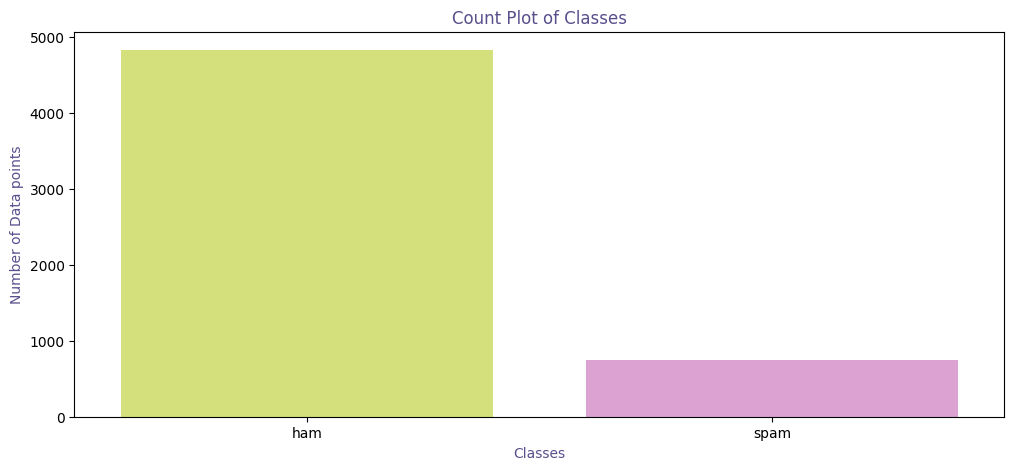

In [3]:
# Palette
cols= ["#E1F16B", "#E598D8"] 
# first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,5))
fg = sns.countplot(x= df["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [4]:
df.describe().T

,count,unique,top,freq
Target,5572,2,ham,4825
Text,5572,5169,"Sorry, I'll call later",30


In [5]:
df['Target'].unique()

array(['ham', 'spam'], dtype=object)

In [6]:
#Label encode the Target and use it as y
label_encoder = preprocessing.LabelEncoder()
df['Target'] = label_encoder.fit_transform(df["Target"])

In [7]:
df.head()

,Target,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# splitting the data into train and test sets
train_data,test_data = train_test_split(df,test_size=0.2,random_state=43)

### Data Preprocessing

##### Lemmatization
- Stemming:- is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

- lemmatization:- also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

##### Stopwords
Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [12]:
nltk.download('wordnet')
nltk.download('stopwords')

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda Text : lower_case(Text))
    df.Text=df.Text.apply(lambda Text : remove_stop_words(Text))
    df.Text=df.Text.apply(lambda Text : removing_numbers(Text))
    df.Text=df.Text.apply(lambda Text : removing_punctuations(Text))
    df.Text=df.Text.apply(lambda Text : removing_urls(Text))
    df.Text=df.Text.apply(lambda Text : lemmatization(Text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= removing_numbers(sentence)
    sentence= removing_punctuations(sentence)
    sentence= removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raunak.Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raunak.Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
normalized_sentence("That's it? It's done already? This is one")

'that s it done already one'

In [13]:
train_data = normalize_text(train_data)
test_data = normalize_text(test_data)

In [14]:
display(train_data.shape)
display(test_data.shape)

(4457, 2)

(1115, 2)

In [15]:
train_data.head()

,Target,Text
424,0,send ur friend receive something ur voice spea...
587,0,pete please ring meive hardly gotany credit
4024,0,lt gt mca conform
3941,0,borderline yeah whatever
5440,0,thank you generally date brothas


### feature engineering

In [16]:
# Splitting the data into features and target variable
X_train = train_data['Text'].values
y_train = train_data['Target'].values

X_test = test_data['Text'].values
y_test = test_data['Target'].values

#### VECTORIZE
TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

* Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

Steps in the Vectorizing:

- Creating a corpus of lemmatized text
- Converting the corpus in vector form
- Label Encoding the classes in Target
Note: So far we have been stalking up columns in our data for the purpose of explanation

In [21]:
# Apply Bag of Words (CountVectorizer)
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform it
X_train_bow = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_bow = vectorizer.transform(X_test)

In [23]:
train_df = pd.DataFrame(X_train_bow.toarray())

train_df['label'] = y_train
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6392,6393,6394,6395,6396,6397,6398,6399,6400,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#### Model building 

#### Model building
**Steps involved in the Model Building**

1. Setting up features and target as X and y
2. Splitting the testing and training sets
3. Build a pipeline of model for four different classifiers.
- Logistic Regression
- Naïve Bayes
- RandomForestClassifier
- KNeighborsClassifier
- Support Vector Machines
4. Fit all the models on training data
5. Get the cross-validation on the training set for all the models for accuracy

In [26]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC(),
               LogisticRegression()]
for cls in classifiers:
    cls.fit(X_train_bow, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC",4:'LogisticRegg'}

# Cross-validation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train_bow,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.973973 
RandomForest: 0.976441 
KNeighbours: 0.921916 
SVC: 0.975992 
LogisticRegg: 0.980705 


In [27]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_scores = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train_bow)
    pred_test = i.predict(X_test_bow)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train_bow,y_train)
    test_accuracy = i.score(X_test_bow,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_scores.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [28]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_scores,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC","LogisticRegg"])

In [29]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.948052,0.941935,0.944984,0.984753,0.991923
RandomForest,0.977273,0.832258,0.898955,0.973991,1.000000
KNeighbours,1.000000,0.400000,0.571429,0.916592,0.938524
SVC,0.992248,0.825806,0.901408,0.974888,0.995513
LogisticRegg,0.970803,0.858065,0.910959,0.976682,0.994615


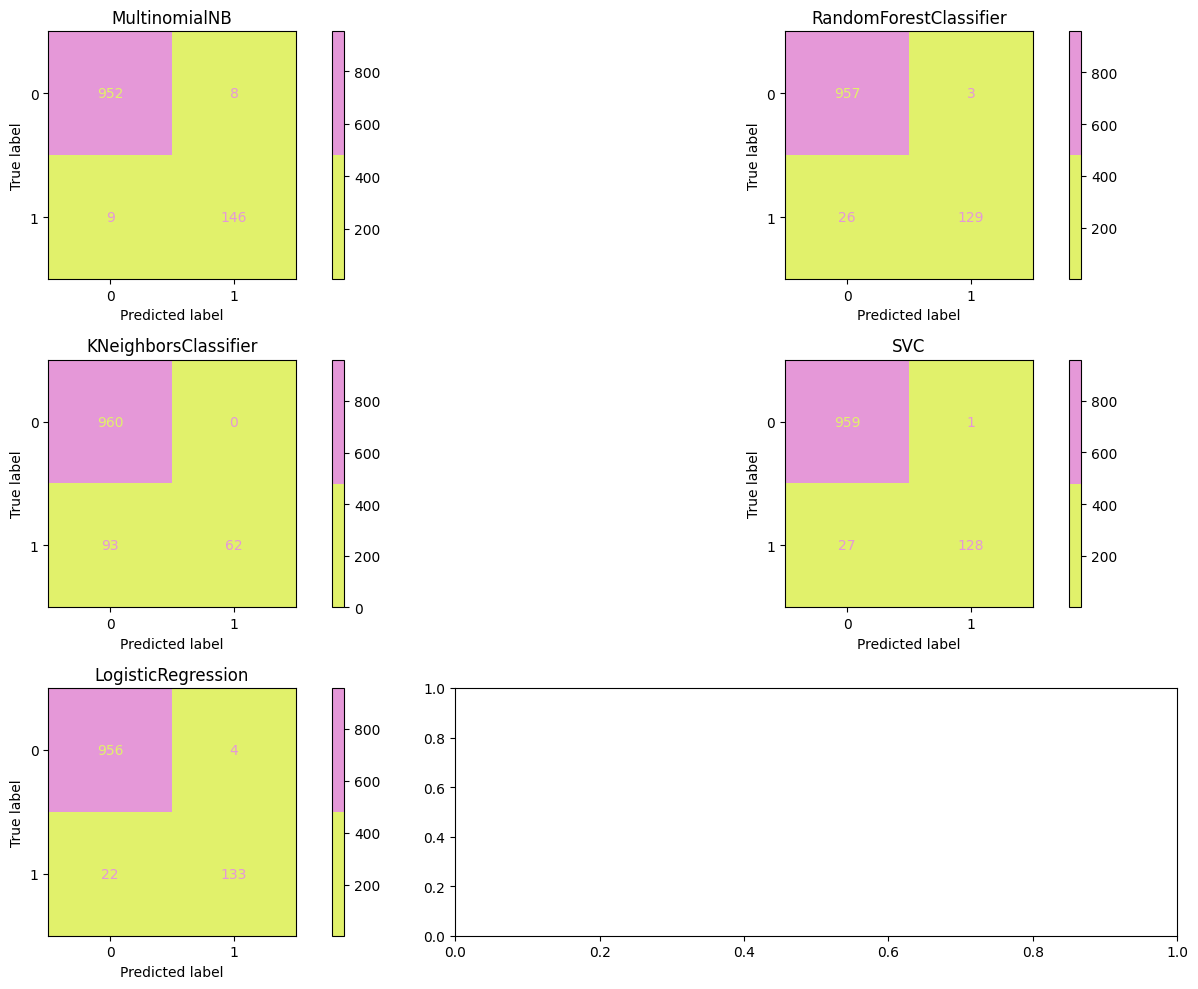

In [31]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(cls, 
                          X_test_bow, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

#### Fitting the Final model and get reports

##### Model building

In [34]:
# Define and train the XGBoost model
final_model = LogisticRegression()
final_model.fit(X_train_bow, y_train)

# Make predictions
y_pred = final_model.predict(X_test_bow)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9766816143497757
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       960
           1       0.97      0.86      0.91       155

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



##### Model evaluation

In [35]:
# Make predictions
y_pred = final_model.predict(X_test_bow)
y_pred_proba = final_model.predict_proba(X_test_bow)[:, 1]

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

In [36]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

Precision: 0.9708029197080292
Recall: 0.8580645161290322
AUC: 0.9906384408602151
